In [1]:
! export PYTHONPATH="$PYTHONPATH:$HOME/generic_implementation/POISEVAE"

In [2]:
import glob 

import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F  # activation function
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

from joint_dataset import MNIST_SVHN
from POISEVAE import POISEVAE # Remember to do export PYTHONPATH ...
from POISEVAE import util

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['text.usetex'] = False

In [3]:
class EncMNIST(nn.Module):
    def __init__(self, latent_dim):
        super(EncMNIST, self).__init__()
        self.latent_dim = latent_dim
        self.dim_MNIST = 28 * 28

        self.enc1 = nn.Linear(self.dim_MNIST, 400)
        self.enc_mu = nn.Linear(400, latent_dim)
        self.enc_var = nn.Linear(400, latent_dim)

    def forward(self, x):
        x = F.relu(self.enc1(x))
        mu = self.enc_mu(x)
        log_var = self.enc_var(x)
        return mu, log_var

class DecMNIST(nn.Module):
    def __init__(self, latent_dim):
        super(DecMNIST, self).__init__()  
        self.latent_dim = latent_dim
        self.dim_MNIST   = 28 * 28
        
        self.dec = nn.Sequential(nn.Linear(self.latent_dim, 400), 
                                 nn.ReLU(inplace=True), 
                                 nn.Linear(400, self.dim_MNIST))
        
    def forward(self, x):
        return self.dec(x)

In [4]:
class EncSVHN(nn.Module):
    def __init__(self, latent_dim):
        super(EncSVHN, self).__init__()
        self.latent_dim = latent_dim
        
        n_channels = (3, 32, 64, 128)
        kernels = (4, 4, 4)
        strides = (2, 2, 2)
        paddings = (1, 1, 1)
        li = []
        for i, (n, k, s, p) in enumerate(zip(n_channels[1:], kernels, strides, paddings), 1):
            li += [nn.Conv2d(n_channels[i-1], n, kernel_size=k, stride=s, padding=p), 
                   nn.ReLU(inplace=True)]
            
        self.enc = nn.Sequential(*li)
        self.enc_mu = nn.Conv2d(in_channels=128, out_channels=latent_dim, 
                                kernel_size=4, stride=1, padding=0)
        self.enc_var = nn.Conv2d(in_channels=128, out_channels=latent_dim, 
                                 kernel_size=4, stride=1, padding=0)
        
    def forward(self, x):
        x = self.enc(x)
        # Be careful not to squeeze the batch dimension if batch size = 1
        mu = self.enc_mu(x).squeeze(3).squeeze(2)
        log_var = self.enc_var(x).squeeze(3).squeeze(2)
        return mu, log_var
    
class DecSVHN(nn.Module):
    def __init__(self, latent_dim):
        super(DecSVHN, self).__init__()  
        self.latent_dim = latent_dim
        
        n_channels = (latent_dim, 128, 64, 32, 3)
        kernels = (4, 4, 4, 4)
        strides = (1, 2, 2, 2)
        paddings = (0, 1, 1, 1)
        li = []
        for i, (n, k, s, p) in enumerate(zip(n_channels[1:], kernels, strides, paddings), 1):
            li += [nn.ConvTranspose2d(n_channels[i-1], n, kernel_size=k, stride=s, padding=p), 
                   nn.ReLU(inplace=True)]
        li[-1] = nn.Sigmoid()
        
        self.dec = nn.Sequential(*li)
        
    def forward(self, x):
        x = self.dec(x)
        return x

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
MNIST_PATH = 'MNIST/MNIST/processed/%s.pt'
SVHN_PATH = 'SVHN/%s_32x32.mat'

joint_dataset_train = MNIST_SVHN(mnist_pt_path=MNIST_PATH % 'train', svhn_mat_path=SVHN_PATH % 'train')
joint_dataset_test = MNIST_SVHN(mnist_pt_path=MNIST_PATH % 'test', svhn_mat_path=SVHN_PATH % 'test')

In [7]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(joint_dataset_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(joint_dataset_test, batch_size=batch_size, shuffle=True)
len(train_loader), len(test_loader)

(938, 157)

In [8]:
lat1, lat2 = 20, 20
enc_mnist = EncMNIST(lat1).to(device)
dec_mnist = DecMNIST(lat1).to(device)
enc_svhn = EncSVHN(lat2).to(device)
dec_svhn = DecSVHN(lat2).to(device)

def MSELoss(input, target):
    loss = nn.functional.mse_loss(input, target, reduction='sum') #/ batch_size
    return loss
    
def MAELoss(input, target):
    loss = nn.functional.l1_loss(input, target, reduction='sum') #/ batch_size
    return loss
    
vae = POISEVAE([enc_mnist, enc_svhn], [dec_mnist, dec_svhn], [MSELoss, MSELoss], 
               latent_dims=[lat1, (lat2, 1, 1)]).to(device)

In [9]:
# for i in vae.named_parameters():
#     print(i[0])

In [10]:
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

In [11]:
PATH = 'MNIST_SVHN_train_results/'

In [12]:
epoch = 0
# try:
#     vae, optimizer, epoch = load_checkpoint(vae, optimizer, sorted(glob.glob(PATH + 'train*.pt'))[-1])
# except:
#     pass

In [13]:
train_loss = []
test_loss = []
epochs = 30 + epoch
for epoch in range(epoch, epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_losses = util.train(vae, train_loader, optimizer, epoch)
    train_loss.append(train_epoch_losses)
    ret = util.test(vae, test_loader, epoch, record_idx=(2, 3), return_latents=True)
    test_epoch_losses, labels, latent_info = ret[:4], ret[-2], ret[-1]
    test_loss.append(test_epoch_losses)
    print(f"Train Loss: %.4f\n\tRec: %.4f, %.4f\n\tKLD Loss %.4f" % train_epoch_losses)
    print(f"Test Loss: %.4f\n\tRec: %.4f, %.4f\n\tKLD Loss %.4f" % test_epoch_losses)
    if (epoch+1) % 10 == 0 and epoch > 0:
        util.save_checkpoint(vae, optimizer, PATH + 'training_%d.pt' % (epoch+1), epoch+1)
train_loss = np.array(train_loss).T
test_loss = np.array(test_loss).T

Epoch 1 of 30
Train Loss: 92.6107
	Rec: 41.4935, 51.5313
	KLD Loss -0.4141
Test Loss: 78.4903
	Rec: 35.0780, 43.1650
	KLD Loss 0.2473
Epoch 2 of 30
Train Loss: 68.5088
	Rec: 31.9861, 35.6275
	KLD Loss 0.8953
Test Loss: 64.7442
	Rec: 29.9686, 34.1998
	KLD Loss 0.5757
Epoch 3 of 30
Train Loss: 60.1897
	Rec: 28.2156, 31.0434
	KLD Loss 0.9307
Test Loss: 59.1301
	Rec: 26.6474, 32.4346
	KLD Loss 0.0481
Epoch 4 of 30
Train Loss: 55.5746
	Rec: 25.9086, 28.8440
	KLD Loss 0.8221
Test Loss: 57.3994
	Rec: 24.7737, 31.8589
	KLD Loss 0.7667
Epoch 5 of 30
Train Loss: 52.8411
	Rec: 24.3425, 27.8607
	KLD Loss 0.6379
Test Loss: 52.8709
	Rec: 23.8995, 29.5294
	KLD Loss -0.5580
Epoch 6 of 30
Train Loss: 51.0870
	Rec: 23.4169, 27.1338
	KLD Loss 0.5363
Test Loss: 51.2477
	Rec: 22.9320, 28.7009
	KLD Loss -0.3852
Epoch 7 of 30
Train Loss: 49.7111
	Rec: 22.7804, 26.5240
	KLD Loss 0.4068
Test Loss: 49.8887
	Rec: 22.3798, 27.5504
	KLD Loss -0.0415
Epoch 8 of 30
Train Loss: 48.6026
	Rec: 22.3150, 25.9044
	KLD Los

In [14]:
util.save_latent_info(latent_info, PATH)

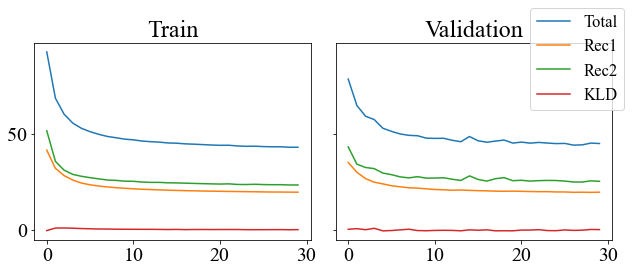

In [15]:
fig, ax = plt.subplots(ncols=2, sharex='all', sharey='all', figsize=(9, 4))

for i, label in enumerate(('Total', 'Rec1', 'Rec2', 'KLD')):
    ax[0].plot(train_loss[i], label=label)
    ax[1].plot(test_loss[i], label=label)
ax[0].set_title('Train')
ax[1].set_title('Validation')
fig.legend(*ax[0].get_legend_handles_labels(), fontsize='small')
fig.tight_layout()

In [16]:
with torch.no_grad():
    for i, data in enumerate(test_loader):
        results = vae([data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)])
        break

In [17]:
results['x_rec'][0].shape, data[0].shape

(torch.Size([64, 784]), torch.Size([64, 784]))

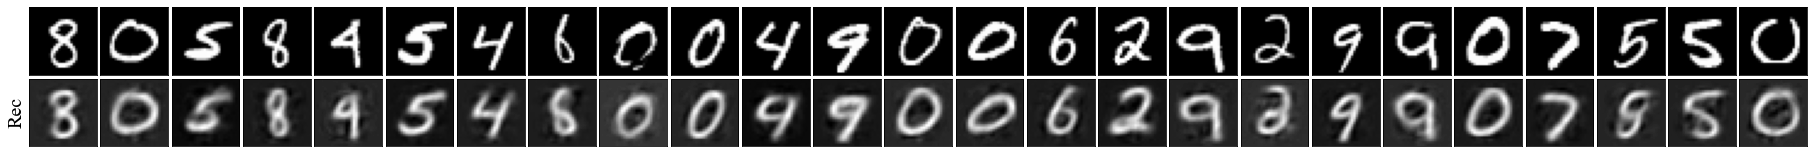

In [18]:
ncols = min(len(results['x_rec'][0]), 25)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(25, 2))
for i, aux in enumerate(zip(data[0], results['x_rec'][0])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=20)
fig.tight_layout(pad=0)

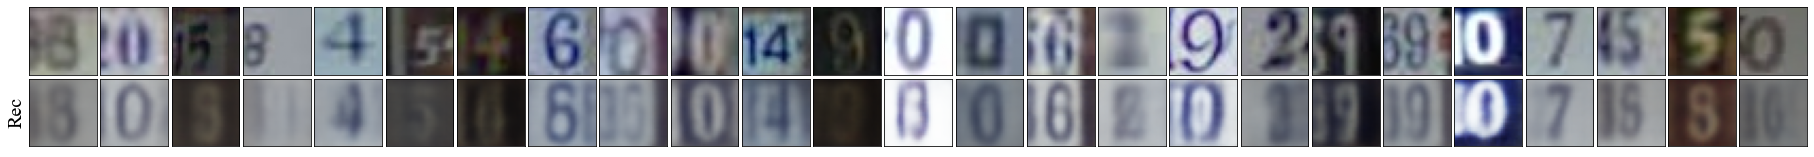

In [19]:
ncols = min(len(results['x_rec'][1]), 25)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(25, 2))
for i, aux in enumerate(zip(data[1], results['x_rec'][1])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().transpose(1, 2, 0))
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=20)
fig.tight_layout(pad=0)